In [499]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer#, TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, plot_roc_curve

In [32]:
df = pd.read_csv('../datasets/subreddits_df.csv')

In [33]:
df.head()

,posts,subreddit,upvotes,num_comments
0,Daily Discussion Thread,nba,26,99
1,[Mod Post] New Mod Application Thread,nba,150,41
2,[Wojnarowski] Sources with @WindhorstESPN : Th...,nba,2948,861
3,[Highlight] Lonzo Ball and Alex Caruso Dish It...,nba,2266,300
4,[Neubeck] After receiving a big fine for missi...,nba,2387,695


In [34]:
df.shape

(1692, 4)

#### Nothing to clean here

In [35]:
print(df.isnull().sum())

posts           0
subreddit       0
upvotes         0
num_comments    0
dtype: int64


### Creating dummy columns for subreddit data

In [36]:
df = pd.get_dummies(df, columns = ['subreddit'], drop_first= True)

In [482]:
df.head()

,posts,upvotes,num_comments,subreddit_warriors
0,Daily Discussion Thread,26,99,0
1,[Mod Post] New Mod Application Thread,150,41,0
2,[Wojnarowski] Sources with @WindhorstESPN : The Brooklyn Nets remain unclear on All-Star guard Kyrie Irving’s ultimate intentions to get vaccinated and have made no decision on whether the organiz...,2948,861,0
3,[Highlight] Lonzo Ball and Alex Caruso Dish It To Zach LaVine For Some Nice Flushes!,2266,300,0
4,"[Neubeck] After receiving a big fine for missing last night's preseason game, sources say Ben Simmons' representation spoke to the players association and had it reiterated the money could not be ...",2387,695,0


In [39]:
X= df['posts']
y= df['subreddit_warriors']

In [40]:
X_train, X_test, y_train, y_test= train_test_split(X, y, random_state = 302123, stratify= y)

In [41]:
# Baseline
y_test.value_counts(normalize=True)

1    0.529551
0    0.470449
Name: subreddit_warriors, dtype: float64

### Model 1 - Logistic Regression

In [148]:
kcount = 0
kmodel_params = {}

In [585]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words= 'english')),
    ('log', LogisticRegression())
])

pipe_params = {
    'cvec__max_features': [2500, 2700, 3000, 3250],
    'cvec__max_df': [.3, .4, .5],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)]
}

In [586]:
##taken from random forrest lesson.

##gridsearch
gs = GridSearchCV(estimator = pipe, param_grid= pipe_params, cv= 5)
gs.fit(X_train, y_train)
count += 1

gs.best_params_['score']= gs.best_score_
model_params[f'model_{count}'] = gs.best_params_
model_df = pd.DataFrame.from_dict(model_params, orient = 'index')
model_df

,cvec__max_df,cvec__max_features,cvec__min_df,cvec__ngram_range,score,dt__max_depth,dt__min_samples_leaf,dt__min_samples_split
model_1,0.90,3000,1.0,"(1, 3)",0.842392,NaN,NaN,NaN
model_2,0.85,4500,NaN,"(1, 3)",0.842389,NaN,NaN,NaN
model_3,0.85,3000,NaN,"(1, 3)",0.842392,NaN,NaN,NaN
model_4,0.85,3000,NaN,"(1, 3)",0.842392,NaN,NaN,NaN
model_5,0.75,3000,NaN,"(1, 3)",0.842392,NaN,NaN,NaN
model_6,0.75,2500,NaN,"(1, 1)",0.734440,7.0,3.0,9.0
model_7,0.75,2500,NaN,"(1, 1)",0.734440,7.0,3.0,9.0
model_22,0.30,3000,NaN,"(1, 3)",0.842392,NaN,NaN,NaN
model_26,0.30,3000,NaN,"(1, 3)",0.842392,NaN,NaN,NaN
model_32,0.30,3000,NaN,"(1, 3)",0.842392,NaN,NaN,NaN


In [587]:
### changing max_df isnt moving the socre in a noticable way so I'll use these params, 
gs.score(X_test, y_test)

0.8486997635933806

In [588]:
preds = gs.predict(X_test)

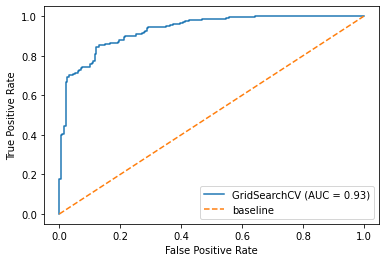

In [589]:
plot_roc_curve(gs, X_test, y_test);
# add worst case scenario line
plt.plot([0,1], [0,1], label = 'baseline', linestyle = '--');
# add a legend
plt.legend();

In [590]:
roc_auc_score(y_test, gs.predict_proba(X_test)[:,1])

0.9318243000717875

In [591]:
confusion_matrix(y_test, preds)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print(f'True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}')

True Negatives: 167, False Positives: 32, False Negatives: 32, True Positives: 192


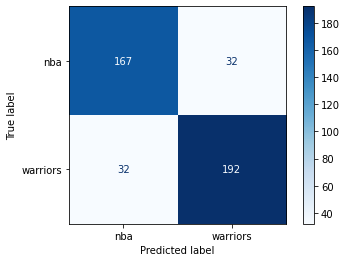

In [592]:
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d', display_labels=['nba', 'warriors']);

### I want to locate false positives in my model because there could be overlap with posts about warriors players

In [554]:
y_test_df = pd.DataFrame(y_test.copy())


In [555]:
pred = pd.DataFrame(preds)
pred = pred.set_index(y_test.index)

new = pd.merge(y_test_df, pred, left_index = True, right_index= True)
new.rename(columns = {'subreddit_warriors': 'war', 0 :'preds'}, inplace = True)

false_pos = new.loc[(new['war'] == 0) & (new['preds'] == 1)] 
lst = false_pos.index
for ele in lst:
    print(df.loc[df.index == ele]['posts'])

630    [Dunc'd On] LA Clippers 2021-22 Season Outlook with Sabreena Merchant
Name: posts, dtype: object
583    Steph Curry on last season: “I heard a lot of noise and I heard a lot of talk about who I wasn't and we were going to get exposed and I was going to get exposed and all that type of stuff,"
Name: posts, dtype: object
632    If you could change one rule or element of the game, what would it be?
Name: posts, dtype: object
727    What is one trade that you can think of that re-unites the most teammates?
Name: posts, dtype: object
486    What do you think is the easiest position to play? What about the hardest?
Name: posts, dtype: object
117    [Slater] The Warriors took 69 threes tonight. They never attempted more than 54 in a game last season.
Name: posts, dtype: object
668    The case for the Warriors to aggressively try to trade for Ben Simmons
Name: posts, dtype: object
621    Weekly Friday Self-Promotion and Fan Art Thread
Name: posts, dtype: object
634    Rasheed Wallace st

#### 10 false positives are explicitly related to the warriors (Had to use human moderator to identify)

In [593]:
## actual classifications
confusion_matrix(y_test, preds)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print(f'True Negatives: {tn}, False Positives: {fp-10}, False Negatives: {fn}, True Positives: {tp+10}')

True Negatives: 167, False Positives: 22, False Negatives: 32, True Positives: 202


In [594]:
## Sensitivity
(tp+10) / ((tp+10) + (fn))

0.8632478632478633

In [595]:
## Precision
(tp+10)/ ((tp+10)+(fp-10))

0.9017857142857143

In [596]:
## Accuracy
(tp+10+tn) / (tp+fn+fp+tn)

0.8723404255319149

### Model 2- KNN

In [491]:
kcount = 0
kmodel_params = {}

In [492]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words= 'english')),
    ('knn', KNeighborsClassifier())
])

pipe_params = {
    'cvec__max_features': [2000, 3000, 4000, 5000],
    'cvec__max_df': [.3, .4, .5, .6],
    'cvec__ngram_range': [(1,1), (1,2)],
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights' : ['uniform', 'distance'],
    'knn__algorithm' : ['auto', 'brute'],
    'knn__leaf_size' : [25, 30, 35],
    'knn__p' : [1,2]
}

In [493]:
##gridsearch
gs = GridSearchCV(estimator = pipe, param_grid= pipe_params, cv= 5)
gs.fit(X_train, y_train)
count += 1

gs.best_params_['score']= gs.best_score_
kmodel_params[f'model_{count}'] = gs.best_params_
kmodel_df = pd.DataFrame.from_dict(kmodel_params, orient = 'index')
kmodel_df

,cvec__max_df,cvec__max_features,cvec__ngram_range,knn__algorithm,knn__leaf_size,knn__n_neighbors,knn__p,knn__weights,score
model_33,0.3,2000,"(1, 2)",auto,25,3,2,uniform,0.608325


In [494]:
gs.score(X_test, y_test)

0.5862884160756501

In [495]:
preds = gs.predict(X_test)

In [496]:
confusion_matrix(y_test, preds)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print(f'True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}')

True Negatives: 36, False Positives: 163, False Negatives: 12, True Positives: 212


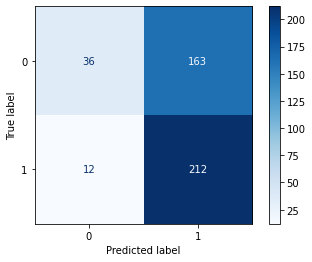

In [497]:
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

In [ ]:
pred = pd.DataFrame(preds)
pred = pred.set_index(y_test.index)

new = pd.merge(y_test_df, pred, left_index = True, right_index= True)
new.rename(columns = {'subreddit_warriors': 'war', 0 :'preds'}, inplace = True)

false_pos = new.loc[(new['war'] == 0) & (new['preds'] == 1)] 
lst = false_pos.index
for ele in lst:
    print(df.loc[df.index == ele]['posts'])

In [500]:
## too many for me to manually count

### Model 3 - Descision Tree Classifier

In [162]:
dcount = 0
dmodel_params = {}

In [163]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words= 'english')),
    ('dt', DecisionTreeClassifier())
])

pipe_params = {
    'cvec__max_features': [2700, 2850, 3000, 3250],
    'cvec__max_df': [.45, .47, .5, .53],
    'cvec__ngram_range': [(1,1), (1,2)],
    'dt__max_depth' : [13, 15, 17, 21],
    'dt__min_samples_split' : [8, 9, 10],
    'dt__min_samples_leaf' : [1, 2, 3, 4]
}

In [164]:
gs = GridSearchCV(estimator = pipe, param_grid= pipe_params, cv= 5)
gs.fit(X_train, y_train)
count += 1

gs.best_params_['score']= gs.best_score_
dmodel_params[f'model_{count}'] = gs.best_params_
dmodel_df = pd.DataFrame.from_dict(dmodel_params, orient = 'index')
dmodel_df
print(gs.score(X_test, y_test))

0.8085106382978723


In [165]:
preds = gs.predict(X_test)

In [166]:
confusion_matrix(y_test, preds)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print(f'True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}')

True Negatives: 182, False Positives: 17, False Negatives: 64, True Positives: 160


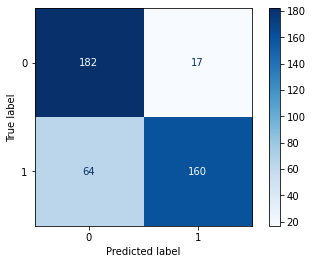

In [167]:
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

### Model 4 - Random Forest Classifier

In [168]:
rcount = 0
rmodel_params = {}

In [569]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words= 'english')),
    ('rf', RandomForestClassifier())
])

pipe_params = {
    'cvec__max_features': [3000, 3250, 3500],
    'cvec__max_df': [.4, .45, .5],
    'cvec__ngram_range': [(1,1), (1,2)],
    'rf__max_depth' : [13, 15, 17],
    'rf__min_samples_split' : [7, 8, 9],
    'rf__min_samples_leaf' : [1, 2]
}

In [ ]:
gs = GridSearchCV(estimator = pipe, param_grid= pipe_params, cv= 5)
gs.fit(X_train, y_train)
count += 1

gs.best_params_['score']= gs.best_score_
rmodel_params[f'model_{count}'] = gs.best_params_
rmodel_df = pd.DataFrame.from_dict(rmodel_params, orient = 'index')
rmodel_df


In [ ]:
gs.score(X_test, y_test)

In [171]:
preds = gs.predict(X_test)


In [172]:
confusion_matrix(y_test, preds)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print(f'True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}')

True Negatives: 174, False Positives: 25, False Negatives: 38, True Positives: 186


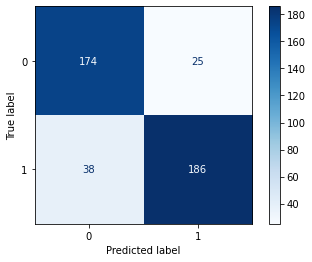

In [173]:
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

### Model 5 - SVC

In [174]:
scount = 0
smodel_params = {}


In [175]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words= 'english')),
    ('svc', SVC())
])

pipe_params = {
    'cvec__max_features': [1500, 1750, 2000, 2250, 2500],
    'cvec__max_df': [.2, .25, .3, .35],
    'cvec__ngram_range': [(1,1), (1,2)],
    'svc__C' : [.5, 1, 2, 5],
    'svc__kernel' : ['linear', 'poly', 'rbf'],
    'svc__degree' : [2] 
}


In [176]:
gs = GridSearchCV(estimator = pipe, param_grid= pipe_params, cv= 5)
gs.fit(X_train, y_train)
count += 1

gs.best_params_['score']= gs.best_score_
smodel_params[f'model_{count}'] = gs.best_params_
smodel_df = pd.DataFrame.from_dict(smodel_params, orient = 'index')
smodel_df

,cvec__max_df,cvec__max_features,cvec__ngram_range,svc__C,svc__degree,svc__kernel,score
model_30,0.2,2000,"(1, 2)",1,2,rbf,0.841598


In [177]:
preds = gs.predict(X_test)


In [178]:
confusion_matrix(y_test, preds)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print(f'True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}')


True Negatives: 168, False Positives: 31, False Negatives: 35, True Positives: 189


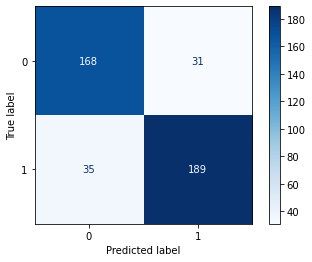

In [179]:
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

### Model 6 - Naive Bayes

In [571]:
ncount = 0
nmodel_params = {}


In [572]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words= 'english')),
    ('nb', MultinomialNB())
])

pipe_params = {
    'cvec__max_features': [5500, 6000, 7000],
    'cvec__max_df': [.25, .27, .3, .33, .35],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'nb__alpha' : [.7, 7.5, .8, .85]
}


In [573]:
gs = GridSearchCV(estimator = pipe, param_grid= pipe_params, cv= 5)
gs.fit(X_train, y_train)
count += 1

gs.best_params_['score']= gs.best_score_
nmodel_params[f'model_{count}'] = gs.best_params_
nmodel_df = pd.DataFrame.from_dict(nmodel_params, orient = 'index')
nmodel_df


,cvec__max_df,cvec__max_features,cvec__ngram_range,nb__alpha,score
model_39,0.25,5500,"(1, 3)",7.5,0.850272


In [574]:
gs.score(X_test, y_test)

0.8534278959810875

In [562]:
preds = gs.predict(X_test)


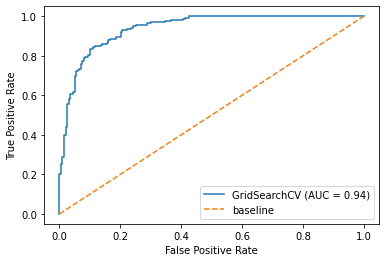

In [563]:
plot_roc_curve(gs, X_test, y_test);
# add worst case scenario line
plt.plot([0,1], [0,1], label = 'baseline', linestyle = '--');
# add a legend
plt.legend();

In [564]:
roc_auc_score(y_test, gs.predict_proba(X_test)[:,1])

0.9388908829863604

In [565]:
confusion_matrix(y_test, preds)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print(f'True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}')


True Negatives: 163, False Positives: 36, False Negatives: 26, True Positives: 198


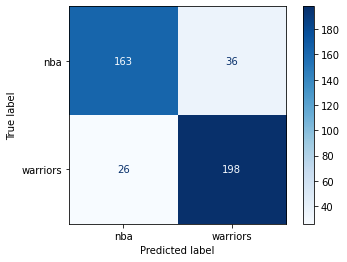

In [578]:
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d', display_labels=['nba', 'warriors']);

In [598]:
pred = pd.DataFrame(preds)
pred = pred.set_index(y_test.index)

new = pd.merge(y_test_df, pred, left_index = True, right_index= True)
new.rename(columns = {'subreddit_warriors': 'war', 0 :'preds'}, inplace = True)

false_pos = new.loc[(new['war'] == 0) & (new['preds'] == 1)] 
lst = false_pos.index
for ele in lst:
    print(df.loc[df.index == ele]['posts'])

630    [Dunc'd On] LA Clippers 2021-22 Season Outlook with Sabreena Merchant
Name: posts, dtype: object
583    Steph Curry on last season: “I heard a lot of noise and I heard a lot of talk about who I wasn't and we were going to get exposed and I was going to get exposed and all that type of stuff,"
Name: posts, dtype: object
632    If you could change one rule or element of the game, what would it be?
Name: posts, dtype: object
727    What is one trade that you can think of that re-unites the most teammates?
Name: posts, dtype: object
486    What do you think is the easiest position to play? What about the hardest?
Name: posts, dtype: object
117    [Slater] The Warriors took 69 threes tonight. They never attempted more than 54 in a game last season.
Name: posts, dtype: object
668    The case for the Warriors to aggressively try to trade for Ben Simmons
Name: posts, dtype: object
621    Weekly Friday Self-Promotion and Fan Art Thread
Name: posts, dtype: object
634    Rasheed Wallace st

In [568]:
# there are 11 false positives relating to the warriors

In [519]:
confusion_matrix(y_test, preds)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print(f'True Negatives: {tn}, False Positives: {fp-11}, False Negatives: {fn}, True Positives: {tp+11}')

True Negatives: 163, False Positives: 25, False Negatives: 26, True Positives: 209


In [525]:
## Sensitivity:
(tp+11) / ((tp+11) + (fn))

0.8893617021276595

In [522]:
## Precision
(tp+11)/ ((tp+11)+(fp-11))

0.8931623931623932

In [523]:
## Accuracy
(tp+11+tn) / (tp+fn+fp+tn)

0.8794326241134752

### Conclusion

The best model was Logistic Regression. It scored higher in the primary classification metric for scoring these models, precision. While Naive Bayes scored higher in both sensitivity and accuracy, precision is a more important metric for this model. It is possible that an aggregated model which uses both of these models could score better than either model individually. Naive Bayes also had a higher ROC AUC which identifies the seperation in the classifier data.

*Sensitivity* is a metric for measuring how many positive posts were correctly identified compared to the total possible positives.
*Precision* is a metric for measuring how many positive post were correctly identified compared to all posts identified as postitive.
*Accuracy* is a metric for measuring how many posts were correctly identified compared to all identified posts.

### Next steps:
Continue modeling for each nba subreddit, the more subreddits this bot is able to post to the faster it gain enough karma to be a product. Filter out already cross posted entries, if a bot is reposting, moderators will take action and attention could be drawn to the bot. 